# Step 0: Load Packages and Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix

# Step 1: Data Loading and Preprocessing

In [35]:
# Read your dataset (replace 'marketing_sample_for_walmart_com-walmart_com_product_review__20200701_20201231__5k_data.tsv' with your dataset path)
train_data = pd.read_csv('/content/clean_data.csv')
train_data.columns

Index(['Unnamed: 0', 'ID', 'ProdID', 'Rating', 'ReviewCount', 'Category',
       'Brand', 'Name', 'ImageURL', 'Description', 'Tags'],
      dtype='object')

In [36]:
train_data = train_data[['ID', 'ProdID', 'Rating', 'ReviewCount', 'Category',
       'Brand', 'Name', 'ImageURL', 'Description', 'Tags']]
train_data.head(3)

,ID,ProdID,Rating,ReviewCount,Category,Brand,Name,ImageURL,Description,Tags
0,1705736792,2,0.0,0.0,"premium, beauty, premium, makeup, premium, nai...",opi,"OPI Infinite Shine, Nail Lacquer Nail Polish, ...",https://i5.walmartimages.com/asr/0e1f4c51-c1a4...,NaN,"premium, beauty, premium, makeup, premium, nai..."
1,95,76,0.0,0.0,"beauty, hair, care, hair, color, auburn, hair,...",easy,"Nice n Easy Permanent Color, 111 Natural Mediu...",https://i5.walmartimages.com/asr/9c8e42e4-13a5...,"pack, 3, pack, 3, upc, 381519000201, beautiful...","beauty, hair, care, hair, color, auburn, hair,..."
2,8,8,4.5,29221.0,"beauty, hair, care, hair, color, permanent, ha...",clairol,Clairol Nice N Easy Permanent Color 7/106A Nat...,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,"clairol, nice, n, easy, permanent, color, give...","beauty, hair, care, hair, color, permanent, ha..."


# Basic Operations

In [37]:
train_data['Tags']

,Tags
0,"premium, beauty, premium, makeup, premium, nai..."
1,"beauty, hair, care, hair, color, auburn, hair,..."
2,"beauty, hair, care, hair, color, permanent, ha..."
3,"beauty, makeup, lip, kokie, cosmetics, calling..."
4,"seasonal, stock, essentials, personal, care, s..."
...,...
4085,"personal, care, incontinence, incontinence, li..."
4086,"pets, dogs, dog, apparel, dog, apparel, dog, s..."
4087,"health, aromatherapy, aromatherapy, pure, gold..."
4088,"household, essentials, air, fresheners, spray,..."


In [38]:
train_data.shape

(4090, 10)

In [39]:
train_data.isnull().sum()

,0
ID,0
ProdID,0
Rating,0
ReviewCount,0
Category,9
Brand,96
Name,0
ImageURL,0
Description,916
Tags,0


In [40]:
# Fill missing values in 'Product Rating' with a default value (e.g., 0)
train_data['Rating'].fillna(0, inplace=True)
# Fill missing values in 'Product Reviews Count' with a default value (e.g., 0)
train_data['ReviewCount'].fillna(0, inplace=True)
# Fill missing values in 'Product Category' with a default value (e.g., 'Unknown')
train_data['Category'].fillna('', inplace=True)
# Fill missing values in 'Product Brand' with a default value (e.g., 'Unknown')
train_data['Brand'].fillna('', inplace=True)
# Fill missing values in 'Product Description' with an empty string
train_data['Description'].fillna('', inplace=True)

/tmp/ipython-input-1541776923.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Rating'].fillna(0, inplace=True)
/tmp/ipython-input-1541776923.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [41]:
train_data.isnull().sum()

,0
ID,0
ProdID,0
Rating,0
ReviewCount,0
Category,0
Brand,0
Name,0
ImageURL,0
Description,0
Tags,0


In [42]:
train_data.duplicated().sum()

np.int64(0)

In [43]:

# make columns shorter
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'Uniq Id': 'ID',
    'Product Id': 'ProdID',
    'Product Rating': 'Rating',
    'Product Reviews Count': 'ReviewCount',
    'Product Category': 'Category',
    'Product Brand': 'Brand',
    'Product Name': 'Name',
    'Product Image Url': 'ImageURL',
    'Product Description': 'Description',
    'Product Tags': 'Tags',
    'Product Contents': 'Contents'
}
# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

In [44]:
train_data['ID'] = train_data['ID'].astype(float)
train_data['ProdID'] = train_data['ProdID'].astype(float)

# Step 2: EDA (Exploratory Data Analysis)

In [45]:

# Basic statistics
num_users = train_data['ID'].nunique()
num_items = train_data['ProdID'].nunique()
num_ratings = train_data['Rating'].nunique()
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")

Number of unique users: 1666
Number of unique items: 1607
Number of unique ratings: 36


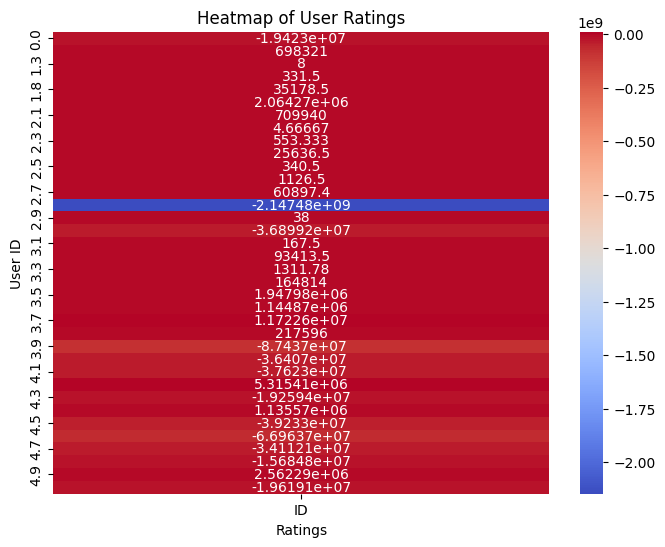

In [46]:
# Pivot the DataFrame to create a heatmap
heatmap_data = train_data.pivot_table('ID', 'Rating')

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='coolwarm', cbar=True)
plt.title('Heatmap of User Ratings')
plt.xlabel('Ratings')
plt.ylabel('User ID')
plt.show()

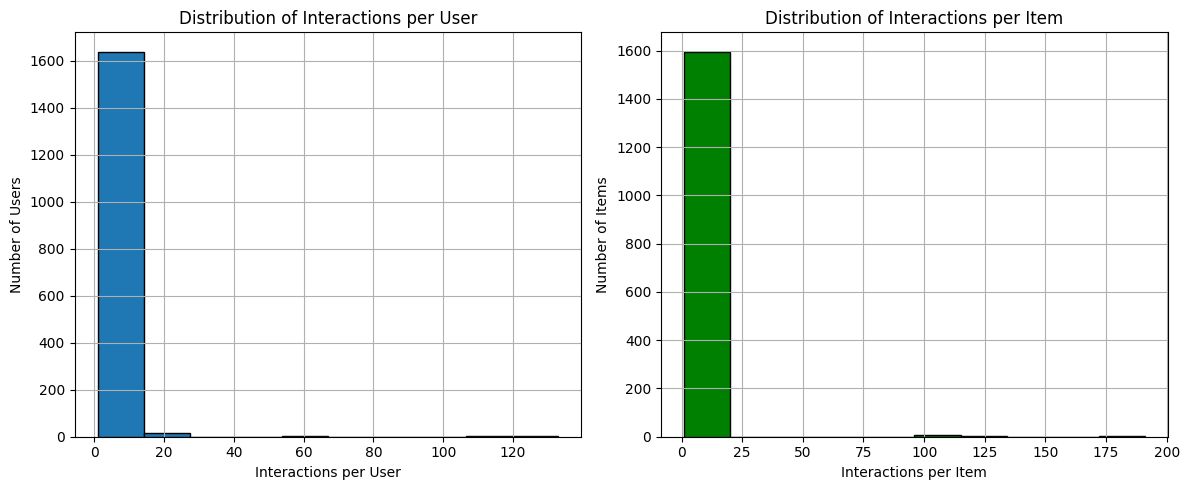

In [47]:
# Distribution of interactions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
train_data['ID'].value_counts().hist(bins=10, edgecolor='k')
plt.xlabel('Interactions per User')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User')

plt.subplot(1, 2, 2)
train_data['ProdID'].value_counts().hist(bins=10, edgecolor='k',color='green')
plt.xlabel('Interactions per Item')
plt.ylabel('Number of Items')
plt.title('Distribution of Interactions per Item')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Most Popular items')

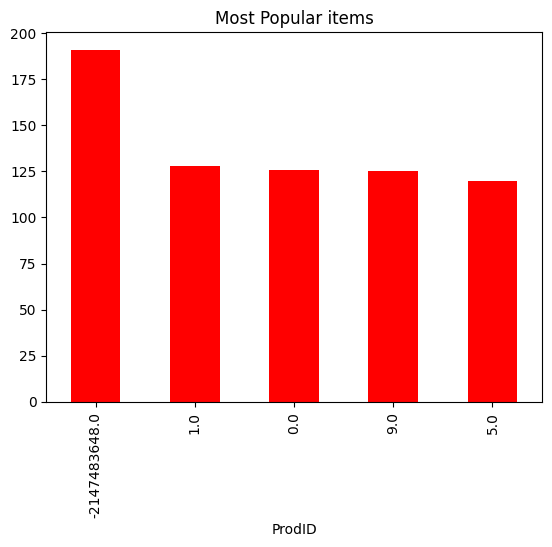

In [48]:
# Most popular items
popular_items = train_data['ProdID'].value_counts().head(5)
popular_items.plot(kind='bar',color='red')
plt.title("Most Popular items")

<Axes: xlabel='Rating'>

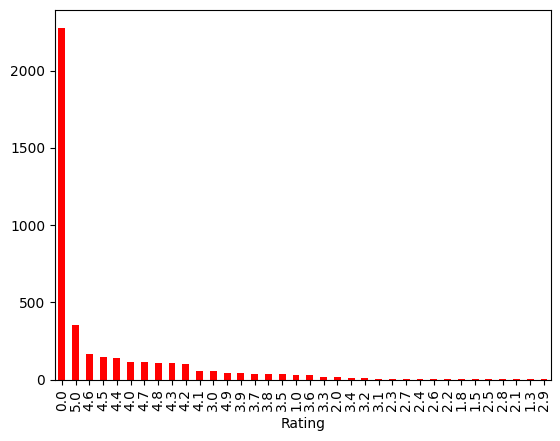

In [49]:
# most rated counts
train_data['Rating'].value_counts().plot(kind='bar',color='red')

# Step 3: Data Cleaning and Tags Creations

In [50]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    doc = nlp(text.lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['Category', 'Brand', 'Description']

for column in columns_to_extract_tags_from:
    train_data[column] = train_data[column].apply(clean_and_extract_tags)

In [51]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

# Rating Base Recommendations System

In [52]:
average_ratings = train_data.groupby(['Name','ReviewCount','Brand','ImageURL'])['Rating'].mean().reset_index()

In [53]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items.head(10)

In [54]:
top_rated_items = average_ratings.sort_values(by='Rating', ascending=False)

rating_base_recommendation = top_rated_items[['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']].head(10)

In [55]:
print("Rating Base Recommendation System: (Trending Products)")
rating_base_recommendation

Rating Base Recommendation System: (Trending Products)


,Name,ReviewCount,Brand,ImageURL,Rating
1,($100 Value) Peter Thomas Roth Thermal Therapy...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/ecd851ef-6ca7...,5.0
14,($33 Value) Sol De Janeiro Carnaval Shimmer Gi...,2.0,"sol, de, janeiro",https://i5.walmartimages.com/asr/433fca9d-d5c2...,5.0
10,($206 Value) Peter Thomas Roth Face Mask Frenz...,1.0,"peter, thomas, roth",https://i5.walmartimages.com/asr/f5fae452-5c37...,5.0
9,($19 Value) Jack Black Pit Boss Antiperspirant...,3.0,"jack, black",https://i5.walmartimages.com/asr/d03b6f4e-27e3...,5.0
944,Chlorella Powder Broken Cell,1.0,"holistic, herbal, solutions",https://i5.walmartimages.com/asr/c8af353d-c591...,5.0
4014,"carmex lip balm stick, strawberry, 3 count",1.0,carmex,https://i5.walmartimages.com/asr/adbcfbe8-fb3c...,5.0
4001,"all Free Clear For Sensitive Skin, 110 Loads, ...",4.0,,https://i5.walmartimages.com/asr/9ccd3c7b-f479...,5.0
62,(2 Packs) Crest 4 In 1 Fluoride Anticavity Too...,1.0,crest,https://i5.walmartimages.com/asr/44ea137f-ab6d...,5.0
58,(2 Pack) Spring Valley Apple Cider Vinegar Cap...,2.0,"spring, valley",https://i5.walmartimages.com/asr/7b4c7801-3747...,5.0
1575,"Gaiam Kids Yoga Mat Pink Zebra, 4mm",13.0,gaiam,https://i5.walmartimages.com/asr/1e3a766f-4185...,5.0


# Content Base Recommendation system (User Preferences or Items similarities)

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])
cosine_similarities_content = cosine_similarity(tfidf_matrix_content,tfidf_matrix_content)

In [57]:
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
item_index = train_data[train_data['Name']==item_name].index[0]

In [58]:
similar_items = list(enumerate(cosine_similarities_content[item_index]))

In [59]:
similar_items = sorted(similar_items, key=lambda x:x[1], reverse=True)
top_similar_items = similar_items[1:10]

recommended_items_indics = [x[0] for x in top_similar_items]

In [60]:
train_data.iloc[recommended_items_indics][['Name','ReviewCount','Brand']]

,Name,ReviewCount,Brand
155,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi
183,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi
203,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi
234,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi
318,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi
366,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
392,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi
671,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi
820,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi


# Function To Recommend Products for Content Base

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['Name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['Name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details

In [62]:
# Example: Get content-based recommendations for a specific item
item_name = 'OPI Infinite Shine, Nail Lacquer Nail Polish, Bubble Bath'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
155,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
183,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
203,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
234,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
318,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
366,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
392,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
671,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0


In [63]:
# Example: Get content-based recommendations for a specific item
item_name = 'Kokie Professional Matte Lipstick, Hot Berry, 0.14 fl oz'
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)

content_based_rec

,Name,ReviewCount,Brand,ImageURL,Rating
2870,"Kokie Professional Matte Lipstick, Firecracker...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/8312221b-ed22...,0.0
525,"Kokie Professional Matte Lipstick, Kiss Me, 0....",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/27dd82a2-2b9c...,0.0
3371,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/fdd7498c-319f...,3.4
3398,e.l.f. Mad for Matte 4 Piece Lip Color Set,0.0,cosmetics,https://i5.walmartimages.com/asr/e2d30304-edc9...,0.0
1409,"LOreal Paris Colour Riche Matte Lip Liner, Mat...",495.0,paris,https://i5.walmartimages.com/asr/baf97085-7231...,4.4
2445,Kokie Professional Lip Poudre Liquid Matte Liq...,7.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/31c99d9b-ea11...,3.4
3758,Be Matte Lipstick - Soft Pink,2.0,"city, color",https://i5.walmartimages.com/asr/69e1ec63-be5e...,3.0
1194,Be Matte Lipstick - Baby Pink,2.0,"city, color",https://i5.walmartimages.com/asr/acadf0c0-739f...,3.0


# Collaborative Filtering (User Item Similarity)

In [64]:
user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating',aggfunc='mean').fillna(0).astype(int)

In [65]:
user_similarity = cosine_similarity(user_item_matrix)

In [66]:
target_user_id = 4
target_user_index = user_item_matrix.index.get_loc(target_user_id)

In [67]:
user_similarities = user_similarity[target_user_index]

similar_user_indices = user_similarities.argsort()[::-1][1:]

In [68]:
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    not_rated_by_target_user = (rated_by_similar_user==0) & (user_item_matrix.iloc[target_user_index]==0)

    recommend_items.extend(user_item_matrix.columns[not_rated_by_target_user][:10])

recommended_items_details = train_data[train_data['ProdID'].isin(recommend_items)][['Name','ReviewCount','Brand','ImageURL','Rating']]

In [69]:
recommended_items_details.head(10)

,Name,ReviewCount,Brand,ImageURL,Rating
2,Clairol Nice N Easy Permanent Color 7/106A Nat...,29221.0,clairol,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,4.5
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
4,"Gillette TRAC II Plus Razor Blade Refills, Fit...",131.0,gillette,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,0.0
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
24,Hempz Milk & Honey Herbal Body Moisturizer 2.2...,7.0,hempz,https://i5.walmartimages.com/asr/83e236e5-392c...,0.0
30,2 Pack - AVEENO Active Naturals Intense Relief...,50.0,aveeno,https://i5.walmartimages.com/asr/e87baba7-ece0...,0.0
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
44,(4 pack) Crest Pro-Health Sensitive & Enamel S...,86.0,crest,https://i5.walmartimages.com/asr/cdf23cc1-475a...,0.0
58,Dr. Hauschka Revitalizing Day Cream (Formerly ...,0.0,"dr, hauschka",https://i5.walmartimages.com/asr/330bb65f-24fc...,0.0
60,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3


# Function That Recommend Items

In [70]:
def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='ID', columns='ProdID', values='Rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = []

    for user_index in similar_users_indices:
        # Get items rated by the similar user but not by the target user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        not_rated_by_target_user = (rated_by_similar_user == 0) & (user_item_matrix.iloc[target_user_index] == 0)

        # Extract the item IDs of recommended items
        recommended_items.extend(user_item_matrix.columns[not_rated_by_target_user][:top_n])

    # Get the details of recommended items
    recommended_items_details = train_data[train_data['ProdID'].isin(recommended_items)][['Name', 'ReviewCount', 'Brand', 'ImageURL', 'Rating']]

    return recommended_items_details.head(10)

# Example usage
target_user_id = 4
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec

Top 5 recommendations for User 4:


,Name,ReviewCount,Brand,ImageURL,Rating
2,Clairol Nice N Easy Permanent Color 7/106A Nat...,29221.0,clairol,https://i5.walmartimages.com/asr/e3a601c2-6a2b...,4.5
3,"Kokie Professional Matte Lipstick, Hot Berry, ...",0.0,"kokie, cosmetics",https://i5.walmartimages.com/asr/25b4b467-bc61...,0.0
4,"Gillette TRAC II Plus Razor Blade Refills, Fit...",131.0,gillette,https://i5.walmartimages.com/asr/1a2ebb06-cd01...,0.0
15,Clairol Natural Instincts Demi-Permanent Hair ...,2935.0,clairol,https://i5.walmartimages.com/asr/00a6e54a-e431...,3.7
24,Hempz Milk & Honey Herbal Body Moisturizer 2.2...,7.0,hempz,https://i5.walmartimages.com/asr/83e236e5-392c...,0.0
30,2 Pack - AVEENO Active Naturals Intense Relief...,50.0,aveeno,https://i5.walmartimages.com/asr/e87baba7-ece0...,0.0
33,"DenTek Kids Fun Flossers, Removes Food & Plaqu...",3.0,dentek,https://i5.walmartimages.com/asr/de6e52eb-6e18...,0.0
44,(4 pack) Crest Pro-Health Sensitive & Enamel S...,86.0,crest,https://i5.walmartimages.com/asr/cdf23cc1-475a...,0.0
58,Dr. Hauschka Revitalizing Day Cream (Formerly ...,0.0,"dr, hauschka",https://i5.walmartimages.com/asr/330bb65f-24fc...,0.0
60,"COVERGIRL Exhibitionist Cream Lipstick, 395 Da...",713.0,covergirl,https://i5.walmartimages.com/asr/95076ec0-ffbd...,4.3


# Hybrid Recommendations

In [71]:
# Hybrid Recommendations (Combine Content-Based and Collaborative Filtering)
def hybrid_recommendations(train_data,target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data,item_name, top_n)

    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data,target_user_id, top_n)

    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates()

    return hybrid_rec.head(10)

In [72]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 4 # Change this to the user_id you want recommendations for
item_name = "OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11"  # Change this to the item name
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 4 and Item 'OPI Nail Lacquer Polish .5oz/15mL - This Gown Needs A Crown NL U11':


,Name,ReviewCount,Brand,ImageURL,Rating
155,OPI Nail Lacquer Polish .5oz/15mL - This Gown ...,0.0,opi,https://i5.walmartimages.com/asr/71caed3f-5f83...,0.0
183,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,0.0,opi,https://i5.walmartimages.com/asr/2d6f5147-53a8...,0.0
203,OPI Nail Lacquer - Dont Bossa Nova Me Around -...,0.0,opi,https://i5.walmartimages.com/asr/fd1195d2-8d8d...,0.0
234,OPI Infinite Shine 2 Polish - ISL P33 - Alpaca...,5.0,opi,https://i5.walmartimages.com/asr/7426eb5c-1690...,0.0
318,OPI Gel Polish Fall 2019 Scotland Collection G...,1.0,opi,https://i5.walmartimages.com/asr/79bbbd9f-9a89...,0.0
366,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/744e869c-3500...,5.0
392,"OPI Nail Polish, Strawberry Margarita, 0.5 Fl Oz",57.0,opi,https://i5.walmartimages.com/asr/b95676e5-96ab...,4.4
671,OPI Nail Gel Polish GelColor .5oz/15mL 3 CT Co...,1.0,opi,https://i5.walmartimages.com/asr/c7ba4815-52f7...,5.0
820,OPI- Nail Lacquer-GelColor - &quotLiv&quotin t...,0.0,opi,https://i5.walmartimages.com/asr/98b4194c-e026...,0.0
952,"OPI GelColor Gel Nail Polish, Dulce De Leche, ...",1.0,opi,https://i5.walmartimages.com/asr/c1b2c370-b2d2...,0.0


In [78]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 10 # Change this to the user_id you want recommendations for
item_name = 'Daily Concepts Daily Body Scrubber'  # Change this to the item name

hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=10)

print(f"Top 10 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 10 Hybrid Recommendations for User 10 and Item 'Daily Concepts Daily Body Scrubber':


,Name,ReviewCount,Brand,ImageURL,Rating
3416,"LOccitane Pure Shea Butter, 5 Oz",5.0,,https://i5.walmartimages.com/asr/4ab445a0-2006...,5.0
3691,"LOccitane Shea Butter Ultra Rich Body Lotion, ...",4.0,,https://i5.walmartimages.com/asr/af20ff49-6281...,0.0
2343,Clean W-BB-1725 Clean Shower Fresh Moisture Ri...,1.0,clean,https://i5.walmartimages.com/asr/8d56e3fe-002a...,5.0
1988,Bamboo Charcoal Dew Puff (for blemish-prone sk...,0.0,"dew, puff",https://i5.walmartimages.com/asr/8e64bbb7-30c4...,0.0
1024,14oz First Aid Beauty Ultra Repair Cream Inten...,14.0,"aid, beauty",https://i5.walmartimages.com/asr/6af4f07f-07bc...,4.9
2166,Chinatown 24/7 Body Silk by Bond No. 9 for Wom...,0.0,"bond, 9",https://i5.walmartimages.com/asr/20b8ca44-cc4d...,0.0
226,"Clarins Bust Beauty Firming Lotion, 1.7 Oz",0.0,clarins,https://i5.walmartimages.com/asr/324a4e6a-0bad...,0.0
3263,"EltaMD Intense Moisturizer, 2.8 Oz - 2 Pack",0.0,eltamd,https://i5.walmartimages.com/asr/48202231-5437...,0.0
982,"H2O+ Beauty Sea Salt Body Wash, 12.2 Oz",0.0,beauty,https://i5.walmartimages.com/asr/a5ad6d40-146e...,0.0
2340,H2O+ Beauty Sea Salt Body Wash lot of 4 each 1...,0.0,beauty,https://i5.walmartimages.com/asr/4716af75-ebbf...,0.0
